Gene Ontology aided Compound Protein Binding
Affinity Prediction Using Neural Network

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Input # type: ignore
from tensorflow.keras.layers import BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve, auc

Loading data

In [2]:
df_davis = pd.read_csv("davis-filter.txt", header=None, sep=" ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])
df_kiba = pd.read_csv("kiba.txt", header=None,sep = " ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])

In [3]:

#check for any missing values in train data
print(df_davis.isnull().any().sum())
#check for any missing values in train data
print(df_kiba.isnull().any().sum())

0
0


Merging the datasets

In [26]:
df = df_kiba
df

Using One-Hot encoding for SMILES and AMINO ACIDS sequence

In [27]:
#for amino acid sequence
# Step 1: Extract unique characters from the specified column ('amino_acid_seq')
unique_chars = sorted(set(''.join(df['amino_acid_seq'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['amino_acid_seq_encoded'] = df['amino_acid_seq'].apply(encode_sequence)

#for SMILES sequence
# Step 1: Extract unique characters from the specified column ('SMILES_seq_drug')
unique_chars = sorted(set(''.join(df['SMILES_seq_drug'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['SMILES_seq_drug_encoded'] = df['SMILES_seq_drug'].apply(encode_sequence)


Padding the amino acid and smiles sequences with 0's to ensure uniformity

In [28]:
# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['amino_acid_seq_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['aa_seq_padded'] = list(padded_seqs)

# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['SMILES_seq_drug_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['smiles_seq_padded'] = list(padded_seqs)

#join the padded sequences
df['drug_protein_encoded'] = df.apply(lambda row: np.concatenate([row['aa_seq_padded'], row['smiles_seq_padded']]), axis = 1)

df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score,amino_acid_seq_encoded,SMILES_seq_drug_encoded,aa_seq_padded,smiles_seq_padded,drug_protein_encoded
0,CHEMBL1087421,O00141,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000,"[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,..."
1,CHEMBL1087421,O14920,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000,"[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2..."
2,CHEMBL1087421,O15111,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000,"[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,..."
3,CHEMBL1087421,P00533,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000,"[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,..."
4,CHEMBL1087421,P04626,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000,"[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10..."
...,...,...,...,...,...,...,...,...,...,...
118249,CHEMBL230654,Q13554,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794,"[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4..."
118250,CHEMBL230654,Q13555,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794,"[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,..."
118251,CHEMBL230654,Q13557,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794,"[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4..."
118252,CHEMBL230654,Q16539,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794,"[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ..."


Train-test splitting – Case 2
New proteins in test:
90% proteins are present in the train, with all their drug interactions and remaining proteins with all their interactions are present in test



In [29]:

# Separate proteins into training and test sets (90% for training, 10% for testing)
train_proteins, test_proteins = train_test_split(df['protein_id'].unique(), test_size=0.1, random_state=42)

# Now we can create a train and test dataset by filtering the DataFrame based on the protein ids
train_df = df[df['protein_id'].isin(train_proteins)]
test_df = df[df['protein_id'].isin(test_proteins)]

# Shuffle the final train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


Checking whether the split happened properly

In [30]:
print(train_df.shape)
print(test_df.shape)

train_list = train_df['protein_id'].unique()
test_list = test_df['protein_id'].unique()

for i in test_list:
    if(i in train_list): print("Error")
else: print("Split performed correctly")

(107704, 10)
(10550, 10)
Split performed correctly


Building the Neural Network

In [31]:
model = Sequential()

model.add(Input(shape=(4718,)))

model.add(Dense(800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))

Compiling the model

In [32]:
#Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 800)            │     3,775,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800)            │         3,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        80,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,860,597 (14.73 MB)

 Trainable params: 3,858,765 (14.72 MB)

 Non-trainable params: 1,832 (7.16 KB)

Training the model

In [33]:
x_train = train_df['drug_protein_encoded']
x_train = pad_sequences(x_train, padding='post', dtype='int8')
y_train = train_df['affinity_score']

x_test = test_df['drug_protein_encoded']
x_test = pad_sequences(x_test, padding='post', dtype='int8')
y_test = test_df['affinity_score']

batch_size = 2000
epochs = 20

customLR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1,  
    min_delta=0.0001, 
    min_lr=1e-6,
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test), verbose=1, callbacks = [customLR, early_stopping])

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - loss: 136.7696 - mae: 11.6432 - val_loss: 127.2763 - val_mae: 11.2488 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - loss: 127.1618 - mae: 11.2454 - val_loss: 106.6514 - val_mae: 10.2937 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - loss: 114.4472 - mae: 10.6666 - val_loss: 93.6870 - val_mae: 9.6462 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - loss: 98.4540 - mae: 9.8892 - val_loss: 79.1343 - val_mae: 8.8570 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - loss: 80.6511 - mae: 8.9437 - val_loss: 64.1432 - val_mae: 7.9684 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - loss: 62.4418 - mae: 7.8600 - val_loss: 46.5270 - val_mae: 6.7716 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - loss: 45.3851 - mae: 6.6888 - val_loss: 32.7131 - val_mae: 5.6621

Evaluating the Model

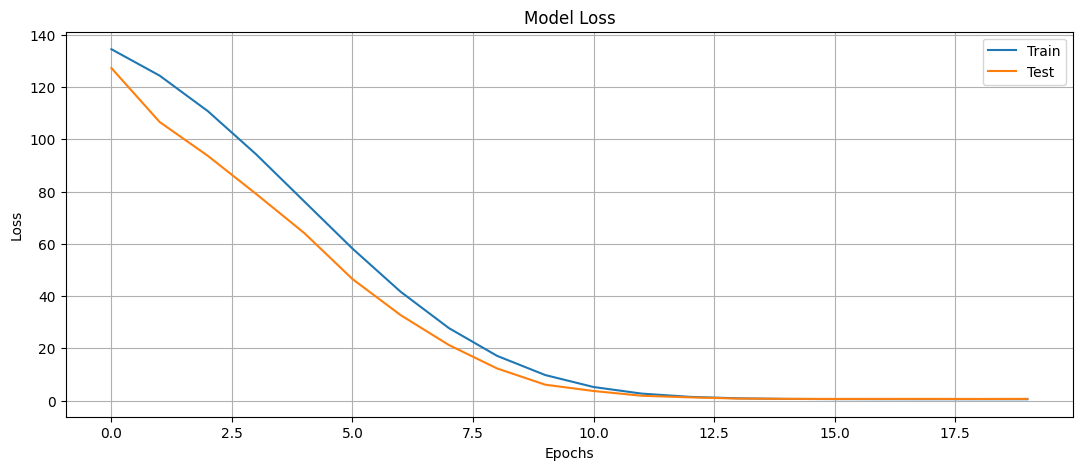

In [34]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

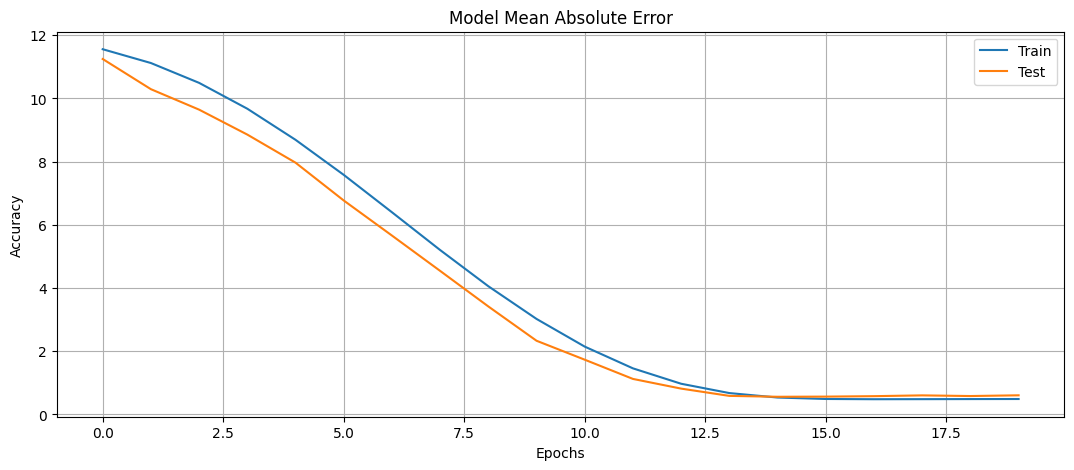

In [35]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

Measuring the performance of model

In [36]:
y_pred = model.predict(x_test).flatten()

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [37]:
# Looking at the predictions
for i in range(len(y_pred)):
    print("actual: ", y_test[i], "predicted: ", y_pred[i])

actual:  12.199999035 predicted:  11.700333
actual:  11.400000202 predicted:  11.460567
actual:  11.900000875 predicted:  11.638365
actual:  11.800000504 predicted:  12.2123575
actual:  11.400000202 predicted:  11.411961
actual:  10.622878745 predicted:  11.250742
actual:  11.1 predicted:  11.496793
actual:  11.1 predicted:  11.543625
actual:  11.1 predicted:  11.434713
actual:  11.699999383 predicted:  11.527595
actual:  11.1 predicted:  11.639528
actual:  11.1 predicted:  11.523325
actual:  10.1 predicted:  11.3570795
actual:  11.1 predicted:  11.673128
actual:  11.200000128 predicted:  12.498595
actual:  12.699997654 predicted:  11.727324
actual:  11.1 predicted:  11.500272
actual:  11.999998417 predicted:  11.589021
actual:  11.900000875 predicted:  11.435544
actual:  11.1 predicted:  12.30842
actual:  11.1 predicted:  11.386063
actual:  11.1 predicted:  11.792399
actual:  11.200000128 predicted:  11.538012
actual:  12.1 predicted:  11.963201
actual:  11.200000128 predicted:  11.60

In [38]:

# Calculate the C-Index
ci = concordance_index(y_test, y_pred)
print("concordance index: " , ci)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("mean_squared_error: ", mse)

# Calculate pearson correlation
pearson_corr, p_value = pearsonr(y_test, y_pred)
print("pearson correlation: ", pearson_corr)

concordance index:  0.6142447684522846
mean_squared_error:  0.6282014660641986
pearson correlation:  0.3181810161795005
